In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder

In [118]:
df = pd.read_csv('how-long-would-you-stay-data-ft-apr-2021/hospital_train.csv', index_col=0)

In [119]:
df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,,,,,,,,,,,,,,,,,
161528,6,a,6,X,2,gynecology,R,F,4.0,45810,2.0,Urgent,Moderate,2,21-30,2817.0,0-10
159472,23,a,6,X,4,gynecology,Q,F,2.0,128565,15.0,Trauma,Moderate,4,51-60,4498.0,21-30
309765,2,c,5,Z,2,anesthesia,S,F,3.0,46565,5.0,Urgent,Moderate,2,71-80,4573.0,11-20
279614,32,f,9,Y,3,gynecology,S,B,4.0,124546,6.0,Emergency,Moderate,4,11-20,7202.0,51-60
147791,14,a,1,X,3,gynecology,S,E,2.0,22729,8.0,Urgent,Moderate,2,51-60,3398.0,51-60


In [120]:
df.drop('10', axis=1, inplace=True)

In [121]:
df.isna().mean()

1     0.00000
2     0.00000
3     0.00000
4     0.00000
5     0.00000
6     0.00000
7     0.00000
8     0.00000
9     0.00033
11    0.01483
12    0.00000
13    0.00000
14    0.00000
15    0.00000
16    0.00000
17    0.00000
dtype: float64

In [122]:
df.dropna(inplace=True)

In [123]:
encoder = LabelEncoder()
df['17'] = encoder.fit_transform(df['17'])

In [124]:
df['17'].unique().shape

(11,)

In [125]:
df = pd.get_dummies(df)

In [126]:
df.head()

,1,3,5,9,11,14,16,17,2_a,2_b,...,15_0-10,15_11-20,15_21-30,15_31-40,15_41-50,15_51-60,15_61-70,15_71-80,15_81-90,15_91-100
0,,,,,,,,,,,,,,,,,,,,,
161528,6,6,2,4.0,2.0,2,2817.0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
159472,23,6,4,2.0,15.0,4,4498.0,2,1,0,...,0,0,0,0,0,1,0,0,0,0
309765,2,5,2,3.0,5.0,2,4573.0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
279614,32,9,3,4.0,6.0,4,7202.0,5,0,0,...,0,1,0,0,0,0,0,0,0,0
147791,14,1,3,2.0,8.0,2,3398.0,5,1,0,...,0,0,0,0,0,1,0,0,0,0


In [127]:
X = df.drop('17', axis=1).to_numpy()
target = df['17'].to_numpy()

In [128]:
model = keras.Sequential()
model.add(keras.Input(shape=(X.shape[1], )))
model.add(keras.layers.Dense(16, activation='relu'),)
model.add(keras.layers.Dense(11, activation="softmax"))

In [129]:
model.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

In [130]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 16)                816       
_________________________________________________________________
dense_11 (Dense)             (None, 11)                187       
Total params: 1,003
Trainable params: 1,003
Non-trainable params: 0
_________________________________________________________________


In [131]:
x_val = X[-10000:-20000:-1]
y_val = target[-10000:-20000:-1]
x_train = X[:-20000]
y_train = target[:-20000]
x_test = X[-10000:]
y_test = target[-10000:]

In [132]:
stop = keras.callbacks.EarlyStopping(
    monitor='sparse_categorical_accuracy', min_delta=0, patience=2, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)


In [133]:
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=15,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
    callbacks=stop
)

Epoch 1/15
1227/1227 [==============================] - 2s 1ms/step - loss: 98.1169 - sparse_categorical_accuracy: 0.1960 - val_loss: 10.1918 - val_sparse_categorical_accuracy: 0.2299
Epoch 2/15
1227/1227 [==============================] - 1s 1ms/step - loss: 10.5371 - sparse_categorical_accuracy: 0.1938 - val_loss: 13.2368 - val_sparse_categorical_accuracy: 0.2792
Epoch 3/15
1227/1227 [==============================] - 1s 976us/step - loss: 10.1945 - sparse_categorical_accuracy: 0.1949 - val_loss: 10.5047 - val_sparse_categorical_accuracy: 0.2478
Epoch 4/15
1227/1227 [==============================] - 1s 1ms/step - loss: 8.7493 - sparse_categorical_accuracy: 0.1979 - val_loss: 7.9186 - val_sparse_categorical_accuracy: 0.2623
Epoch 5/15
1227/1227 [==============================] - 1s 1ms/step - loss: 7.9886 - sparse_categorical_accuracy: 0.1984 - val_loss: 7.4206 - val_sparse_categorical_accuracy: 0.1111
Epoch 6/15
1227/1227 [==============================] - 1s 999us/step - loss: 7.69

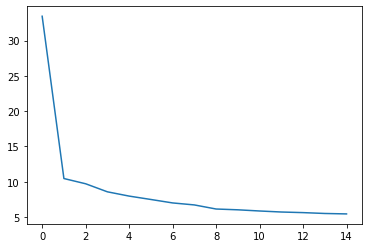

In [134]:
plt.plot(history.history["loss"])

In [135]:
results = model.evaluate(x_test, y_test, batch_size=128)

79/79 [==============================] - 0s 638us/step - loss: 8.6777 - sparse_categorical_accuracy: 0.2483


In [136]:
history = model.fit(
    X,
    target,
    batch_size=64,
    epochs=15,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_test, y_test),
    callbacks=stop
)

Epoch 1/15
1539/1539 [==============================] - 2s 1ms/step - loss: 5.3098 - sparse_categorical_accuracy: 0.2213 - val_loss: 5.3404 - val_sparse_categorical_accuracy: 0.1348
Epoch 2/15
1539/1539 [==============================] - 2s 1ms/step - loss: 5.1774 - sparse_categorical_accuracy: 0.2267 - val_loss: 3.7102 - val_sparse_categorical_accuracy: 0.2823
Epoch 3/15
1539/1539 [==============================] - 2s 1ms/step - loss: 5.0405 - sparse_categorical_accuracy: 0.2271 - val_loss: 8.1839 - val_sparse_categorical_accuracy: 0.1234
Epoch 4/15
1539/1539 [==============================] - 2s 977us/step - loss: 4.9347 - sparse_categorical_accuracy: 0.2277 - val_loss: 6.1763 - val_sparse_categorical_accuracy: 0.2454
Epoch 5/15
1539/1539 [==============================] - 2s 989us/step - loss: 4.7556 - sparse_categorical_accuracy: 0.2292 - val_loss: 4.8687 - val_sparse_categorical_accuracy: 0.0217
Epoch 6/15
1539/1539 [==============================] - 2s 993us/step - loss: 4.3411 -

## Predicción 

In [147]:
sample = pd.read_csv('how-long-would-you-stay-data-ft-apr-2021/hospital_test.csv')

In [148]:
sample = pd.get_dummies(sample).to_numpy()

In [149]:
model.predict(sample)

ValueError: in user code:

    /home/jose/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /home/jose/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/jose/.local/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/jose/.local/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/jose/.local/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/jose/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /home/jose/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /home/jose/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/jose/.local/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:259 assert_input_compatibility
        ' but received input with shape ' + display_shape(x.shape))

    ValueError: Input 0 of layer sequential_5 is incompatible with the layer: expected axis -1 of input shape to have value 50 but received input with shape (None, 52)


### 2. Carga los datos de `diamonds_test.csv` para predecir.

**¿De dónde saco `diamonds_test.csv`?**

In [137]:
predictions_submit = nnc.predict(df_pred)
predictions_submit

NameError: name 'nnc' is not defined

In [ ]:
predictions_submit.shape

In [ ]:
sample = pd.read_csv("sample_submission.csv")

In [ ]:
sample.head()

In [ ]:
sample.shape

In [ ]:
submission = pd.DataFrame({"id": range(len(predictions_submit)), "price": predictions_submit})

In [ ]:
submission.head()

In [ ]:
submission.shape

In [ ]:
def chequeator(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.id.all() == sample.id.all():
                print("You're ready to submit!")
                submission.to_csv("./submission.csv", index = False)     
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("\nMensaje secreto de Clara: No me puedo creer que después de todo este notebook hayas hecho algún cambio en las filas de `diamonds_test.csv`. Lloro.")


In [ ]:
chequeator(submission)

In [ ]:
# import pickle
#
# pickle.dump(nnc, open('modelo.p', 'wb'))